In [69]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from pandas import Series
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import eye, asarray, dot, sum, diag
from scipy.linalg import svd, svdvals
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
from netCDF4 import Dataset
from numpy import linspace
from numpy import meshgrid
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import grangercausalitytests

import PCA_functions as pf
import Extreme_functions as ef

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, CMIknn
import tigramite.data_processing as pp

from statsmodels.tsa.stattools import adfuller
from Data import Data
from datetime import datetime

import itertools
from collections import Counter
import pickle

from numpy import linalg as LA

import matplotlib.cm as cm

import scipy.stats as st

#import reverse_geocoder as rg

from pandas_datareader import wb
import scipy.stats as st

plt.rcParams["figure.figsize"] = (5,5)

import seaborn as sns

from sklearn import preprocessing

import seaborn as sns

plt.rcParams["figure.figsize"] = (20,10)

import Rung as rg

In [6]:
def varimax(Phi, gamma = 1.0, q = 500, 
    rtol = np.finfo(np.float32).eps ** 0.5):
    p,k = Phi.shape
    R = np.eye(k)
    d=0
    # print Phi
    for i in range(q):

        d_old = d
        Lambda = np.dot(Phi, R)
        u,s,vh = np.linalg.svd(np.dot(Phi.T,np.asarray(Lambda)**3 
                   - (gamma/float(p)) * np.dot(Lambda, 
                    np.diag(np.diag(np.dot(Lambda.T,Lambda))))))
        R = np.dot(u,vh)
        d = np.sum(s)
        if d_old!=0 and abs(d - d_old) / d < rtol: break
    # print i
    return np.dot(Phi, R), R

def svd_flip(u, v=None, u_based_decision=True):
    """Sign correction to ensure deterministic output from SVD.
    Adjusts the columns of u and the rows of v such that the loadings in the
    columns in u that are largest in absolute value are always positive.
    Parameters
    ----------
    u, v : ndarray
        u and v are the output of `linalg.svd` or
        `sklearn.utils.extmath.randomized_svd`, with matching inner dimensions
        so one can compute `np.dot(u * s, v)`.
    u_based_decision : boolean, (default=True)
        If True, use the columns of u as the basis for sign flipping.
        Otherwise, use the rows of v. The choice of which variable to base the
        decision on is generally algorithm dependent.
    Returns
    -------
    u_adjusted, v_adjusted : arrays with the same dimensions as the input.
    """
    if v is None:
         # rows of v, columns of u
        max_abs_rows = np.argmax(np.abs(u), axis=0)
        signs = np.sign(u[max_abs_rows, range(u.shape[1])])
        u *= signs
        return u

    if u_based_decision:
        # columns of u, rows of v
        max_abs_cols = np.argmax(np.abs(u), axis=0)
        signs = np.sign(u[max_abs_cols, range(u.shape[1])])
        u *= signs
        v *= signs[:, np.newaxis]
    else:
        # rows of v, columns of u
        max_abs_rows = np.argmax(np.abs(v), axis=1)
        signs = np.sign(v[range(v.shape[0]), max_abs_rows])
        u *= signs
        v *= signs[:, np.newaxis]

    return u, v

def pca_svd(data,
    truncate_by='max_comps', 
    max_comps=38,
    fraction_explained_variance=0.9,
    verbosity=0,
    ):
    """Assumes data of shape (obs, vars).
    https://stats.stackexchange.com/questions/134282/relationship-between-svd-
    and-pca-how-to-use-svd-to-perform-pca
    SVD factorizes the matrix A into two unitary matrices U and Vh, and a 1-D
    array s of singular values (real, non-negative) such that A == U*S*Vh,
    where S is a suitably shaped matrix of zeros with main diagonal s.
    K = min (obs, vars)
    U are of shape (vars, K)
    Vh are loadings of shape (K, obs)
    """

    n_obs = data.shape[0]

    # Center data
    data -= data.mean(axis=0)

    # data_T = np.fastCopyAndTranspose(data)
    # print data.shape

    U, s, Vt = svd(data, 
                full_matrices=False)
                # False, True, True)

    # flip signs so that max(abs()) of each col is positive
    U, Vt = svd_flip(U, Vt, u_based_decision=False)

    V = Vt.T
    S = np.diag(s)   
    # eigenvalues of covariance matrix
    eig = (s ** 2) / (n_obs - 1.)

    # Sort
    idx = eig.argsort()[::-1]
    eig, U = eig[idx], U[:, idx]


    if truncate_by == 'max_comps':

        U = U[:, :max_comps]
        V = V[:, :max_comps]
        S = S[0:max_comps, 0:max_comps]
        explained = np.sum(eig[:max_comps]) / np.sum(eig)

    elif truncate_by == 'fraction_explained_variance':
        # print np.cumsum(s2)[:80] / np.sum(s2)
        max_comps = np.argmax(np.cumsum(eig) / np.sum(eig) > fraction_explained_variance) + 1
        explained = np.sum(eig[:max_comps]) / np.sum(eig)


        U = U[:, :max_comps]
        V = V[:, :max_comps]
        S = S[0:max_comps, 0:max_comps]

    else:
        max_comps = U.shape[1]
        explained = np.sum(eig[:max_comps]) / np.sum(eig)

    # Time series
    ts = U.dot(S)

    return V, U, S, ts, eig, explained, max_comps

In [ ]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def deseasonalize(data,freq=12):
    """
    The shape of data should be (time, index) 
    """
    n  = data.shape[1]
    N  = data.shape[0]
    data_deseasonal = np.zeros(data.shape)
    for i in range(n):
        temp = np.copy(data[:,i])
        temp = np.ravel(temp)
        r = np.zeros((N))
        for j in range(freq):
            Idx = np.arange(j,N,freq)
            if temp[Idx].std() == 0:
                r[Idx] = 0
            else:
                r[Idx] = (temp[Idx] - temp[Idx].mean())/temp[Idx].std()
        data_deseasonal[:,i] = np.copy(r)
    return(data_deseasonal)

In [40]:
level = 12
temporal_limits = {"time_min":datetime(1977, 1, 1, 0, 0),"time_max":datetime(2015, 12, 1, 0, 0)}

In [ ]:
ET_gamma = np.load("ET_gamma.npy")
N = ET_gamma.shape[0]
n_nodes = ET_gamma.shape[1]
extremes_treshold = -1
count = []
for i in range(N):
    count.append(np.count_nonzero(ET_gamma[i,:] <= extremes_treshold))

In [70]:
n_components_sst = 76

sst = Data('../../nc/sst.mnmean.nc','sst',temporal_limits, missing_value= -9.96921e+36)

result_raw = sst.get_data()
lon_sst_list = sst.get_lon_list()
lat_sst_list = sst.get_lat_list()
lon_sst = sst.get_lon()
lat_sst = sst.get_lat()

result_sst = pf.deseasonalize(np.array(result_raw))
weights = np.sqrt(np.abs(np.cos(np.array(lat_sst_list)* math.pi/180)))
for i in range(len(weights)):
    result_sst[:,i] = weights[i] * result_sst[:,i]

data_sst = pd.DataFrame(result_sst)

V, U, S, ts, eig, explained, max_comps = rg.pca_svd(data_sst,truncate_by='max_comps', max_comps=n_components_sst)

Vr, Rot = rg.varimax(V)
Vr = rg.svd_flip(Vr)

# Get explained variance of rotated components
s2 = np.diag(S)**2 / (ts.shape[0] - 1.)

# matrix with diagonal containing variances of rotated components
S2r = np.dot(np.dot(np.transpose(Rot), np.matrix(np.diag(s2))), Rot)
expvar = np.diag(S2r)

sorted_expvar = np.sort(expvar)[::-1]
# s_orig = ((Vt.shape[1] - 1) * s2) ** 0.5

# reorder all elements according to explained variance (descending)
nord = np.argsort(expvar)[::-1]
Vr = Vr[:, nord]

# Get time series of UNMASKED data
comps_ts = np.matmul(np.array(data_sst),Vr)

df_sst = pd.DataFrame({"lons":lon_sst_list,"lats":lat_sst_list})

lon_temp = df_sst["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_sst["lons"].vlues = lon_temp

In [79]:
pc = 0

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


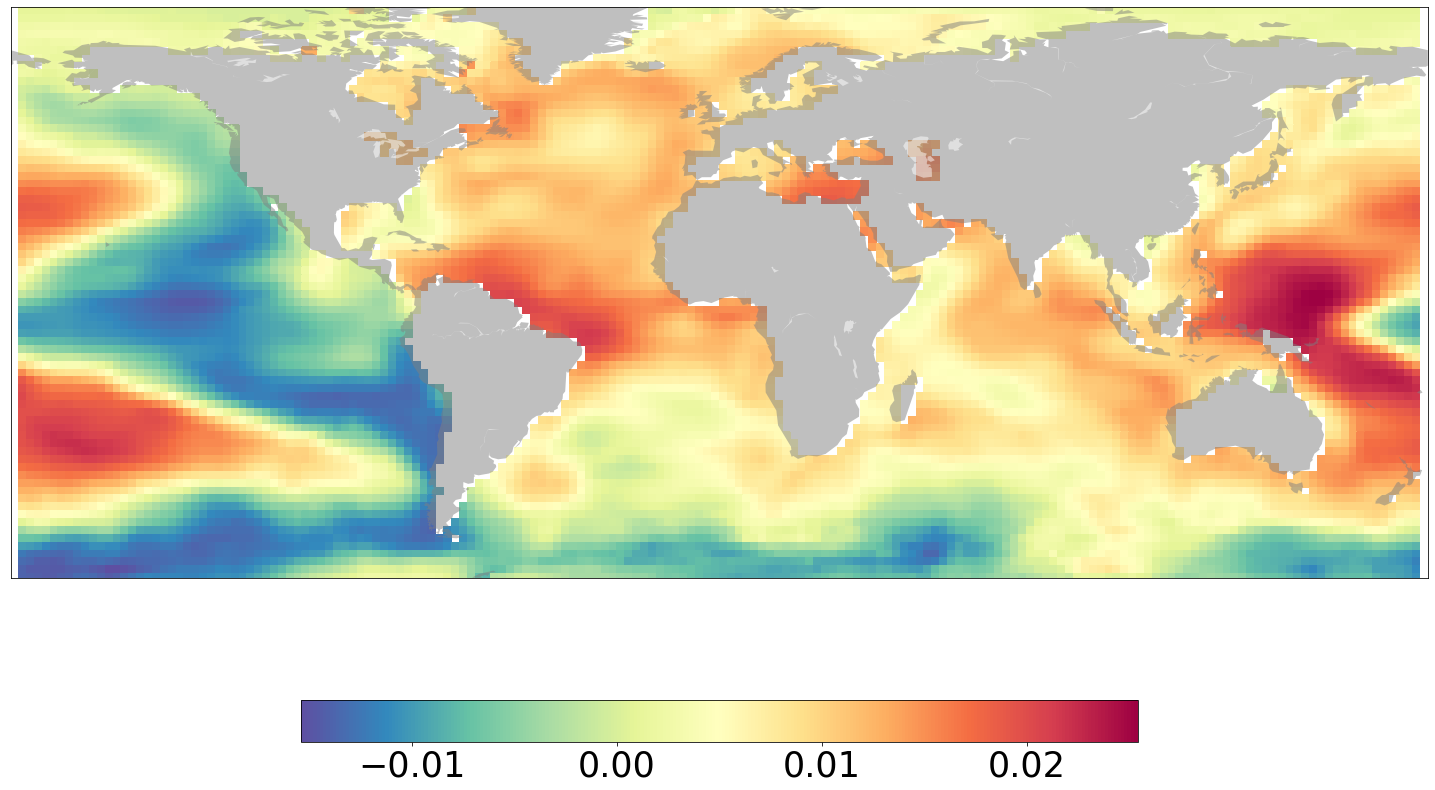

In [80]:
df_sst["pc"] = V[:,pc]

#lon1 = np.arange(-178.75,179.0,2.5)
lon1_sst = np.arange(-180,180,2)
#lat1 = np.arange(-40,40,2.5)

deg = np.zeros((len(lat_sst),len(lon1_sst)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df_sst[(df_sst.lats == lat_sst[i]) & (df_sst.lons == lon1_sst[j])].pc.values.size == 0:
            deg[i,j] = df_sst[(df_sst.lats == lat_sst[i]) & (df_sst.lons == lon1_sst[j])].pc.values
        else:
            deg[i,j]=np.nan


plt.figure(figsize=(30,15))
# Make the background map
#map=Basemap(llcrnrlon=lon1[0], llcrnrlat=lat[-1],urcrnrlon=lon1[-1],urcrnrlat=lat[0])
map = Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
#m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
map.fillcontinents(color='grey', alpha=0.5)
#m.drawcoastlines(linewidth=0.1, color="white")
#map.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
#map.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
map.drawcoastlines(linewidth=0.)


xx, yy = meshgrid(lon1_sst, lat_sst)
cs = map.pcolormesh(xx, yy, deg, cmap=plt.cm.Spectral_r)
#cs = map.contourf(xx, yy, deg, 11, cmap=plt.cm.Spectral_r)
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
cbar.ax.tick_params(labelsize=35)
#plt.clim(-0.1,0.1)
#cbar.set_label('Loadings', fontsize = )
#plt.title("Sea Surface Temperature EOF %d"%(pc+1),fontsize = 40)
#plt.savefig("SST EOF%d_unrotated.png"%(pc+1))
plt.show()

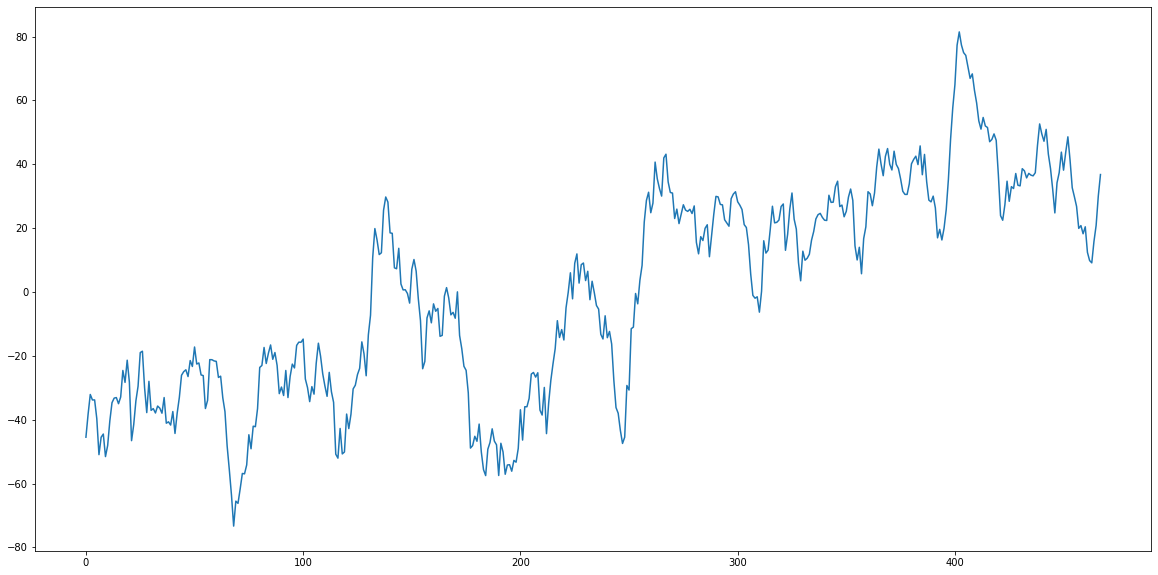

In [71]:
plt.plot(ts[:,0])

In [72]:
comps_ts.shape

(468, 38)